# RESNET triplet loss

## Triplet loss

In [1]:
from dataset import TripletImageFolder, TripletImageTestFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import sys
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) 
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)
        
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out
    

class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
    
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        # Define the convolutional layers and fully connected layers for embeddings
        self.Resnet = ResNet(ResidualBlock, [2,2,2,2], 128)

    def forward_one(self, x):
        # Forward pass through the convolutional layers
        x = self.Resnet(x)
        return x

    def forward(self, anchor, positive, negative):
        # Forward pass for both input1 and input2
        output1 = self.forward_one(anchor)
        output2 = self.forward_one(positive)
        output3 = self.forward_one(negative)
        return output1, output2, output3

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

train_transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomCrop(100, padding=4, padding_mode='reflect'),
        transforms.Grayscale(),
    ])
test_transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(),
    ])

batch_size = 32
num_epochs = 1
# learning_rate = 0.001

train_folder = 'AD_NC/train'
test_folder = 'AD_NC/test'

train_dataset = TripletImageFolder(train_folder, transform=train_transform)
test_dataset = TripletImageTestFolder(test_folder, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device:  cuda


In [6]:
# Initialize the model
model = TripletNet().to(device)
model.load_state_dict(torch.load('old_models/model_S4_v3.pth'))

# Define a loss function and an optimizer
criterion = TripletLoss(0.5)
# learning_rate = 0.0001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# # # #Piecwise Linear Schedule
# sched_linear_1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=learning_rate, step_size_down=15, mode='triangular', verbose=False)
# sched_linear_3 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.005/learning_rate, end_factor=0.005/5, verbose=False)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[sched_linear_1, sched_linear_3], milestones=[30])

In [ ]:
print(num_epochs)
# Training loop
loss_epoch_train = {}
loss_epoch_val = {}
print('start Training: ')
for epoch in range(num_epochs):  # loop over the dataset multiple times
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            model.train()
            dataloader = test_loader
        
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            percentageDone = int((i/ len(dataloader)) * 100)
            if percentageDone % int(len(dataloader) / 85) == 0:
                print(f"\rProgress: {percentageDone}/{100}", end="", flush=True)
                
            anchor, positive, negative = data
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()

            # Forward pass
            output1, output2, output3 = model(anchor, positive, negative)  # Pass two images as inputs
            loss = criterion(output1, output2, output3)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
        print(f"\r", end="", flush=True)
        print(f'{epoch} {phase} Loss: {running_loss / len(dataloader)}')
        if phase == 'train':
            loss_epoch_train[epoch] = running_loss / len(dataloader)
        else:
            loss_epoch_val[epoch] = running_loss / len(dataloader)
        break

print('Finished Training')

torch.save(model.state_dict(), 'model_S4_5_v3.pth')

In [ ]:
print('Finished Training')
torch.save(model.state_dict(), 'model_S4_5_v3.pth')

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

model = TripletNet().to(device)
model.load_state_dict(torch.load('model_S5_5_v3.pth'))

num_correct = 0
num_total = 0
with torch.no_grad():
    for i, images in enumerate(test_loader):
        percentageDone = int((i/ len(test_loader)) * 100)
        if percentageDone % int(len(test_loader) / 200) == 0:
            print(f"\rProgress: {percentageDone}/{100}", end="", flush=True)

        anchor_image, positive_image, negative_image = images
        anchor_image, positive_image, negative_image = anchor_image.to(device), positive_image.to(device), negative_image.to(device)
        
        # Calculate the distances between the embedded images
        anchor_embedding, positive_embedding, negative_embedding = model(anchor_image, positive_image, negative_image)

        anchor_positive_distance = torch.nn.functional.pairwise_distance(anchor_embedding, positive_embedding)
        anchor_negative_distance = torch.nn.functional.pairwise_distance(anchor_embedding, negative_embedding)
        # If the anchor-positive distance is smaller than the anchor-negative distance, then the triplet Siamese network has correctly classified the triplet
        for i in range(len(anchor_positive_distance)):
            num_total += 1
            if anchor_positive_distance[i] < anchor_negative_distance[i]:
                num_correct += 1

        # num_total += len(images)

accuracy = num_correct / num_total
print("")
print(num_correct, num_total)
print(f'Test Accuracy: {int(accuracy*100)}%')

device:  cuda
Progress: 99/100
7272 9000
Test Accuracy: 80%


Run 1:

Progress: 99/100
5274 9000
Test Accuracy: 58%

Run 1:
Progress: 99/100
4776 9000
Test Accuracy: 53%

Run 2:
Progress: 99/100
7116 9000
Test Accuracy: 79%

Run 3:
Progress: 99/100
7272 9000
Test Accuracy: 80%

## Classifier

In [7]:
from dataset import TripletImageFolder, TripletImageTestFolder, get_datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import numpy as np

In [9]:
tripleNet = TripletNet().to(device)
tripleNet.load_state_dict(torch.load('old_models/model_S7_v3.pth'))

def extract_features(data):
    with torch.no_grad():
        embeddings = tripleNet.forward_one(data)
        return embeddings

In [10]:
class TripletNetClassifier(nn.Module):
    def __init__(self):
        super(TripletNetClassifier, self).__init__()
        # Define the convolutional layers and fully connected layers for embeddings
        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

train_transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomCrop(100, padding=4, padding_mode='reflect'),
        transforms.Grayscale(),
    ])
test_transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(),
    ])

batch_size = 32
# learning_rate = 0.001

train_folder = 'AD_NC/train'
test_folder = 'AD_NC/test'

train, test = get_datasets('AD_NC', test_transform)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)


device:  cuda


In [12]:
import torch.nn as nn

# Load the Triplet network
tripleClassifier = TripletNetClassifier().to(device)
tripleClassifier.load_state_dict(torch.load('old_models/tripleClassifier_4.pth'))

# Define a loss function (e.g., cross-entropy) and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(tripleClassifier.parameters(), lr=0.01)
optimizer = torch.optim.Adam(tripleClassifier.parameters(), lr=0.001)

In [65]:
t_loss = {}
v_loss = {}
num_epochs = 1
# Train the classifier using labeled data
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            continue
            tripleClassifier.train()
            dataloader = train_loader
        else:
            tripleClassifier.eval()
            dataloader = test_loader
        
        running_loss = 0.0
        for i, data in enumerate(dataloader):

            percentageDone = int((i/ len(dataloader)) * 100)
            if percentageDone % int(len(dataloader) / 200) == 0:
                print(f"\rProgress: {percentageDone}/{100}", end="", flush=True)

            input, label = data
            input, label = input.to(device), label.to(device)
            features = extract_features(input)
            optimizer.zero_grad()
            outputs = tripleClassifier(features)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"\r", end="", flush=True)
        print(f'{epoch} Loss: {running_loss / len(dataloader)}')
        if phase == 'train':
            t_loss[epoch] = running_loss / len(dataloader)
        else:
            v_loss[epoch] = running_loss / len(dataloader)

torch.save(tripleClassifier.state_dict(), 'tripleClassifier_4.pth')

0 Loss: 0.05520094551167134
0 Loss: 0.4982811524301556
1 Loss: 0.05320710390119469
1 Loss: 0.4990545539779866
2 Loss: 0.05312177981275935
2 Loss: 0.49526548264085823
3 Loss: 0.05349643274535941
3 Loss: 0.49361412047494385
4 Loss: 0.05379627509892643
4 Loss: 0.495419682657465


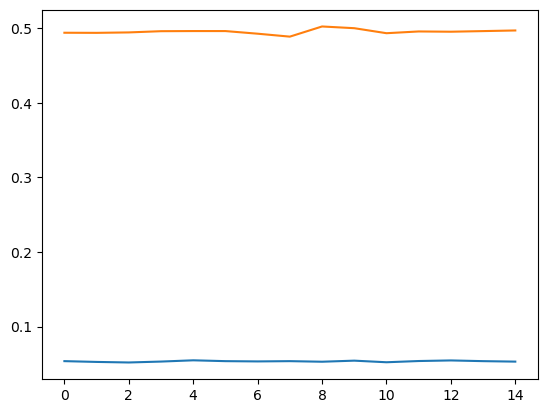

In [62]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(t_loss.keys()), list(t_loss.values()))
plt.plot(list(v_loss.keys()), list(v_loss.values()))
plt.show()

# Loss


In [ ]:
0 Loss: 0.030736041104673224
1 Loss: 0.028336447940199714
2 Loss: 0.029379969842421107
3 Loss: 0.023456681206869792
4 Loss: 0.027751883586169288
5 Loss: 0.025700981068231318
6 Loss: 0.02131699164672555
7 Loss: 0.024060125680567947
8 Loss: 0.02496514272121287
9 Loss: 0.02080872764324501
10 Loss: 0.021142935658372018
11 Loss: 0.016225117209498617
12 Loss: 0.019073867044855898
13 Loss: 0.021928831933599114
14 Loss: 0.017006159249778694

0 Loss: 0.1479588593155655
0 Loss: 0.7808590598985659
1 Loss: 0.13496145961617975
1 Loss: 0.7936575772069024
2 Loss: 0.27145624826392395
2 Loss: 0.7701689505830724
3 Loss: 0.16680264508283876
3 Loss: 0.7891913066941796
4 Loss: 0.12896722332570276
4 Loss: 0.7683067531027692
5 Loss: 0.1325459842757636
5 Loss: 0.7490276447001923
6 Loss: 0.14713766949561274
6 Loss: 0.6943010344361582
7 Loss: 0.06828085187892464
7 Loss: 0.7345658597793985
8 Loss: 0.08703689743507996
8 Loss: 0.713349996940464
9 Loss: 0.12349410339332646
9 Loss: 0.8499348588446354
10 Loss: 0.18494013116350239
10 Loss: 0.8608756779778933
11 Loss: 0.1813073224106279
11 Loss: 0.8066919431196037
12 Loss: 0.0843949568076011
12 Loss: 0.7197277905247735
13 Loss: 0.12148014057376097
13 Loss: 0.7651713412281469
14 Loss: 0.13576616931286845
14 Loss: 0.787752554137656


0 Loss: 0.05381284814535877
0 Loss: 0.493861364240342
1 Loss: 0.052752976967343566
1 Loss: 0.4937183386150827
2 Loss: 0.052013993215891445
2 Loss: 0.49430245792506433
3 Loss: 0.0532388188881401
3 Loss: 0.4959435199803494
4 Loss: 0.05491504495991823
4 Loss: 0.4961224951325579
5 Loss: 0.05379929908144428
5 Loss: 0.49610631062206645
6 Loss: 0.05343187056560717
6 Loss: 0.4925810222296005
7 Loss: 0.05379184411053669
7 Loss: 0.4886484627499648
8 Loss: 0.053020458164580585
8 Loss: 0.5022609925016444
9 Loss: 0.05445295956970385
9 Loss: 0.4999620553026808
10 Loss: 0.05231570330302108
10 Loss: 0.4932426516468643
11 Loss: 0.053961907558068414
11 Loss: 0.49559278923568995
12 Loss: 0.05475151959985196
12 Loss: 0.49523798022287113
13 Loss: 0.05379928348715352
13 Loss: 0.4960704633952878
14 Loss: 0.05316612225281556
14 Loss: 0.49691390346550773

0 Loss: 0.05520094551167134
0 Loss: 0.4982811524301556
1 Loss: 0.05320710390119469
1 Loss: 0.4990545539779866
2 Loss: 0.05312177981275935
2 Loss: 0.49526548264085823
3 Loss: 0.05349643274535941
3 Loss: 0.49361412047494385
4 Loss: 0.05379627509892643
4 Loss: 0.495419682657465

In [13]:
tripleClassifier.eval()  # Set the model to evaluation mode
with torch.no_grad():

    correct = 0
    total = 0

    # Initialize a dictionary to store class-wise accuracy
    class_correct = {i: 0 for i in range(2)}
    class_total = {i: 0 for i in range(2)}

    for batch in test_loader:
        test_X, test_y = batch
        test_X, test_y = test_X.to(device), test_y.to(device)

        # Forward pass
        features = extract_features(test_X)
        test_outputs = tripleClassifier(features)
        _, predicted = torch.max(test_outputs, 1)
        # Compute overall accuracy
        correct += (predicted == test_y).sum().item()
        total += test_y.size(0)
        # Compute class-wise accuracy
        for i in range(2):
            class_total[i] += (test_y == i).sum().item()
            class_correct[i] += (predicted == i)[test_y == i].sum().item()

    overall_accuracy = correct / total
    print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

    # Print class-wise accuracy
    for i in range(2):
        class_accuracy = class_correct[i] / class_total[i]
        print(f"Class {i} Accuracy: {class_accuracy:.4f}")

Overall Test Accuracy: 0.7801
Class 0 Accuracy: 0.7381
Class 1 Accuracy: 0.8214


# other 

torch.Size([1, 100, 100])


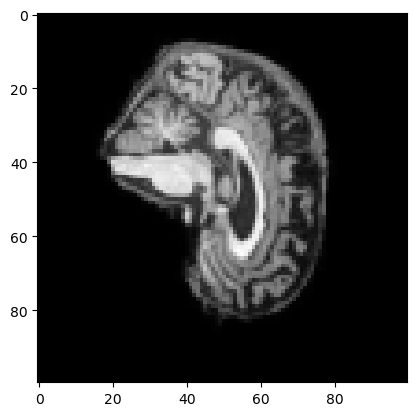

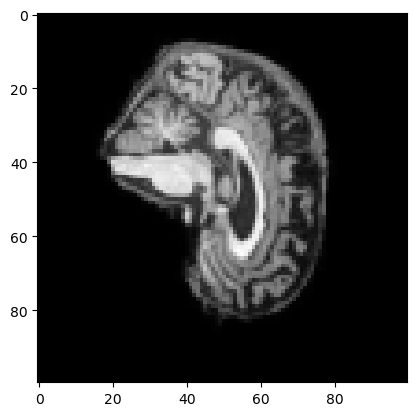

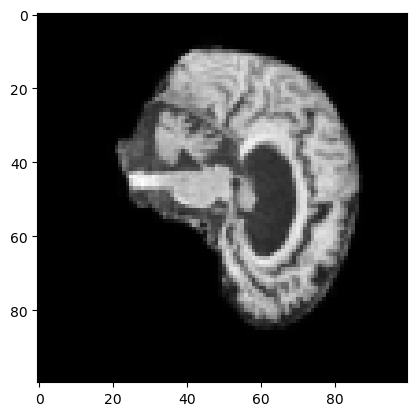

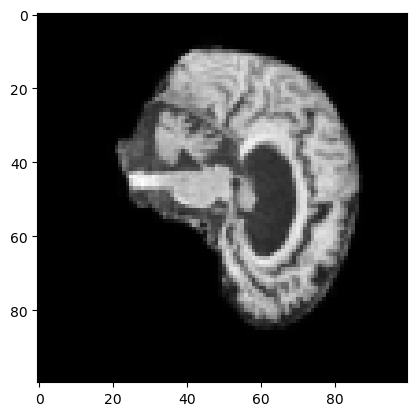

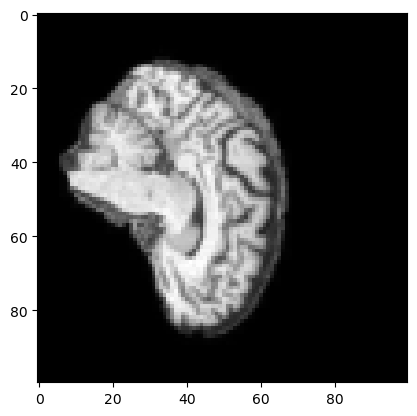

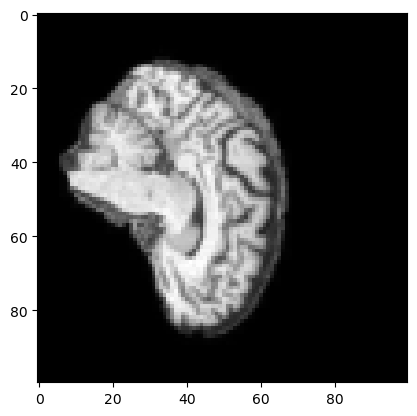

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
print(test_dataset[0][0].shape)
plt.imshow(np.transpose(test_dataset[0][0].numpy(), (1, 2, 0)), cmap='gray')
plt.show()
plt.imshow(np.transpose(test_dataset[0][0].numpy(), (1, 2, 0)), cmap='gray')
plt.show()
plt.imshow(np.transpose(test_dataset[0][1].numpy(), (1, 2, 0)), cmap='gray')
plt.show()
plt.imshow(np.transpose(test_dataset[0][1].numpy(), (1, 2, 0)), cmap='gray')
plt.show()
plt.imshow(np.transpose(test_dataset[0][2].numpy(), (1, 2, 0)), cmap='gray')
plt.show()
plt.imshow(np.transpose(test_dataset[0][2].numpy(), (1, 2, 0)), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 206, 818)


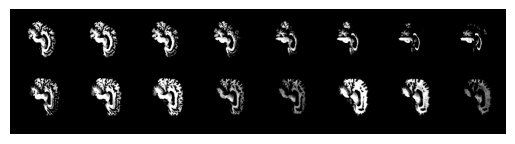

tensor(1.)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
transform = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(),
    ])

def imshow(img, text=None):
    npimg = img.numpy()
    print(npimg.shape)
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

example_batch = train[1]
example_batch_1 = example_batch[0].numpy()
example_batch_1 = torch.tensor([[example_batch_1[i]] for i in range(8)])
example_batch_2 = example_batch[1].numpy()
example_batch_2 = torch.tensor([[example_batch_2[i]] for i in range(8)])



# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch_1, example_batch_2),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2])